In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-folder/Cleaned_Nepali_dataset.csv
/kaggle/input/bert-folder/raw_dataset/raw_dataset/dataset_dict.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/data-00000-of-00001.arrow


In [2]:
!pip install -q --upgrade pip
!pip install -q --upgrade ipywidgets 
!pip install -q datasets
!pip install -q tqdm
!pip uninstall -q -y tensorflow 
!pip uninstall -q -y keras 
!pip install -q tf-keras  # To satisfy transformers' internal requirement for now

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 55.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


# This notebook is all about the Performance on validation of v3 of Nephased(fine tune of distilbert-base-nepali)

In [4]:
!cp -R /kaggle/input/bert-folder/raw_dataset/raw_dataset /kaggle/working/

In [5]:
from datasets import Dataset, load_from_disk

dataset = load_from_disk("/kaggle/working/raw_dataset")

train = dataset["train"]
validation = dataset["validation"]

train = train.rename_column("label", "labels")
validation = validation.rename_column("label", "labels")

print(train)
print(validation)

Dataset({
    features: ['text', 'labels'],
    num_rows: 2287
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 572
})


## Class count in Dataset
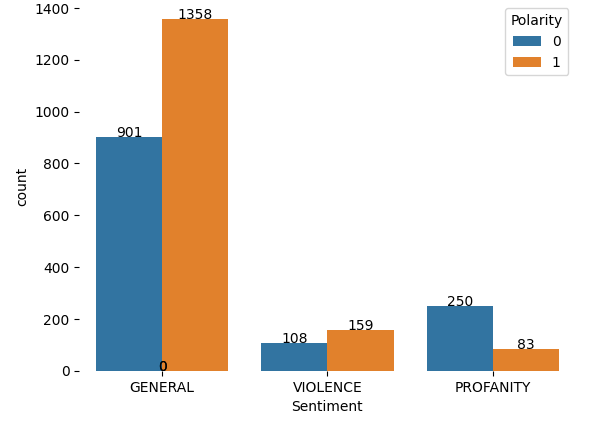
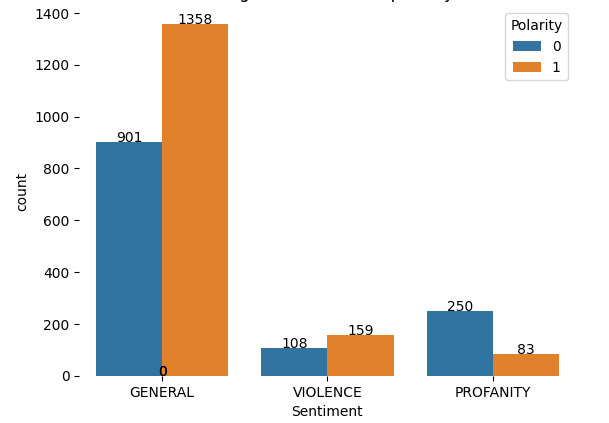

In [6]:
from collections import Counter

for k, v in dataset.items():
    print(k, Counter(dataset[k]['label']))

train Counter({0: 1807, 3: 214, 1: 200, 2: 66})
validation Counter({0: 452, 3: 53, 1: 50, 2: 17})


## Loading model

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "Vyke2000/Nephased"

tokenizer= AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [8]:
# Generating Embeddings
def preprocess_function(document):
    return tokenizer(document["text"], truncation=True, padding='max_length')

train_tokenized= train.map(preprocess_function, batched= False,remove_columns=["text"])
validation_tokenized= validation.map(preprocess_function, batched= False,remove_columns=["text"])

# Convert to DataFrame and reorder columns
train2 = pd.DataFrame(train_tokenized)
train2 = train2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
train_tokenized = Dataset.from_pandas(train2)
train_tokenized = train_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])

validation2 = pd.DataFrame(validation_tokenized)
validation2 = validation2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
validation_tokenized = Dataset.from_pandas(validation2)
validation_tokenized = validation_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])



print(validation_tokenized.features.keys())

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [9]:
# Evaluation Setup
import torch
from torch import nn
import pickle
from scipy.special import softmax
from sklearn.metrics import classification_report, roc_curve, auc

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probabilities = softmax(logits, axis=-1)  
    
    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']

    # Setup for ROC curve

    # Get number of classes
    num_classes = probabilities.shape[1]

    roc_auc_all = np.zeros(num_classes)  # AUC scores
    fpr_all = []  # List of FPR arrays (each index corresponds to a class)
    tpr_all = []  # List of TPR arrays (each index corresponds to a class)

    for i in range(num_classes):
        # OvR method for ROC
        binary_labels = (labels == i).astype(int)
        fpr, tpr, _ = roc_curve(binary_labels, probabilities[:, i])
        roc_auc = auc(fpr, tpr)

        # Store results
        roc_auc_all[i] = roc_auc
        fpr_all.append(fpr)
        tpr_all.append(tpr)

    # Save arrays to a pickle file
    roc_data = {"roc_auc": roc_auc_all, "fpr": fpr_all, "tpr": tpr_all}
    with open("/kaggle/working/roc_data.pkl", "wb") as f:
        pickle.dump(roc_data, f)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

class_weights = torch.tensor([0.03909412, 0.07128872, 0.7817872,  0.14956193], dtype= torch.float32)

# Custom loss function
def compute_loss_func(outputs, labels, num_items_in_batch=None):
    num_labels = 4 # Adjust according to task
    logits = outputs.logits
    weights_for_loss = class_weights.to(logits.device)
    loss_fct = nn.CrossEntropyLoss(weight=weights_for_loss)
    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
    return loss



In [10]:
# Load pre-trained Model
model= AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [11]:
from transformers import TrainingArguments, Trainer

run_name= "Nephased_validation"
output_dir = "/kaggle/working/Nephased"

training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    do_train=False,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    warmup_ratio= 0.17707559519779958,
    save_total_limit=1,
    learning_rate=1.9165942005355648e-05,
    num_train_epochs=20,
    weight_decay=0.09172868307357833,
    report_to="wandb",
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    save_strategy = "epoch",
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
    seed= 42,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss_func, # Loss function with weights
)

In [13]:
# wandb for logging, get the login key from wandb.ai/authorize
!pip install -q wandb
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

wandb: Currently logged in as: tamangangel2057 (tamangangel2057-student). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [15]:
wandb.init()
trainer.evaluate()

{'eval_loss': 0.8645288348197937,
 'eval_accuracy': 0.7814685314685315,
 'eval_recall': 0.6420804563267952,
 'eval_precision': 0.6362363939378157,
 'eval_f1': 0.6293581418535559,
 'eval_runtime': 4.1343,
 'eval_samples_per_second': 138.354,
 'eval_steps_per_second': 2.177}

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       452
           1       0.36      0.60      0.45        50
           2       0.86      0.71      0.77        17
           3       0.42      0.42      0.42        53

    accuracy                           0.78       572
   macro avg       0.64      0.64      0.63       572
weighted avg       0.81      0.78      0.79       572



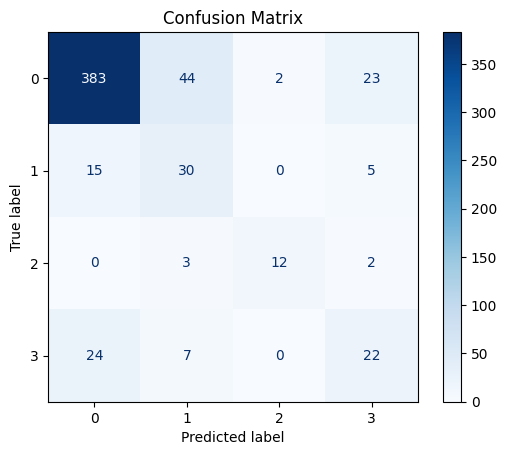

In [16]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# # Load the test dataset
# test_dataset = load_from_disk("/kaggle/working/validation_tokenized")

predictions = trainer.predict(validation_tokenized)
final_predictions = np.argmax(predictions.predictions, axis=1)

label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}

prediction_data = []
for gt, pt in zip(validation_tokenized['labels'], final_predictions):
    prediction_data.append([gt, pt])
    
prediction_df = pd.DataFrame(prediction_data, columns=['labels', 'predictions'])
# Convert tensor labels to integers
prediction_df['labels'] = prediction_df['labels'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

report = classification_report(y_true=prediction_df['labels'], y_pred=prediction_df['predictions'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_true= prediction_df['labels'], y_pred= prediction_df['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(prediction_df['labels']))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

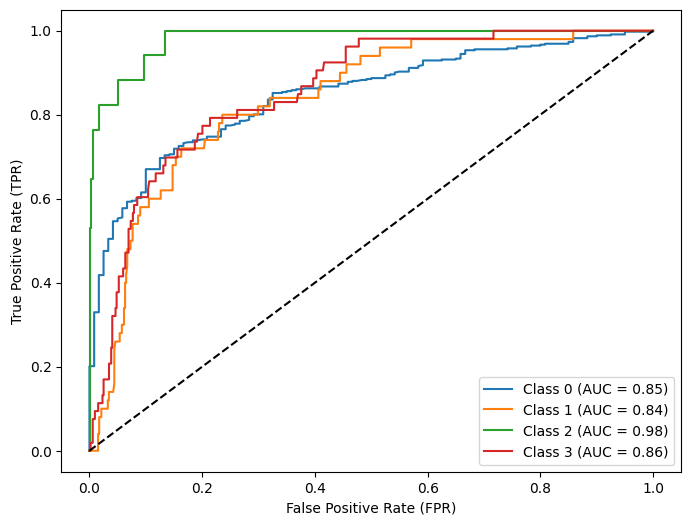

In [17]:
# Load the ROC data
with open("/kaggle/working/roc_data.pkl", "rb") as f:
    roc_data = pickle.load(f)

# Extract FPR, TPR, and AUC values
roc_auc_all = roc_data["roc_auc"]
fpr_all = roc_data["fpr"]
tpr_all = roc_data["tpr"]

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(roc_auc_all)):
    plt.plot(fpr_all[i], tpr_all[i], label=f"Class {i} (AUC = {roc_auc_all[i]:.2f})")

# Plot baseline (random guess)
plt.plot([0, 1], [0, 1], 'k--')

# Formatting
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()

### For Learning curve we will simply take the training log from last DE run's [Nephased model](https://github.com/angeltamang123/Nepali-Hate-Sentiment-Detection/blob/main/Project/finetune%20of%20distilbert-base-nepali/bert-differential-evolution-checkpoint2.ipynb) and hardcode the losses in an array 
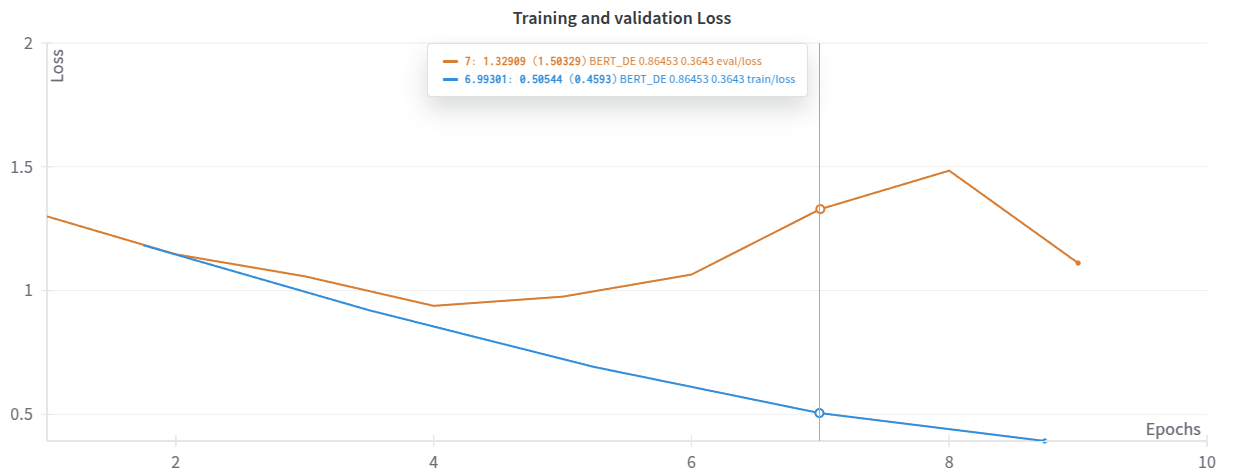
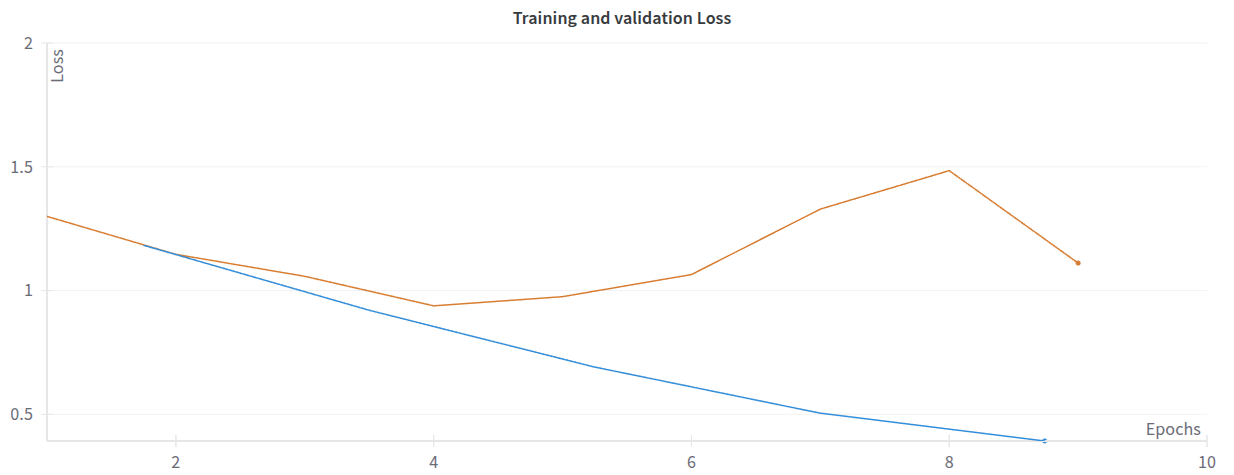

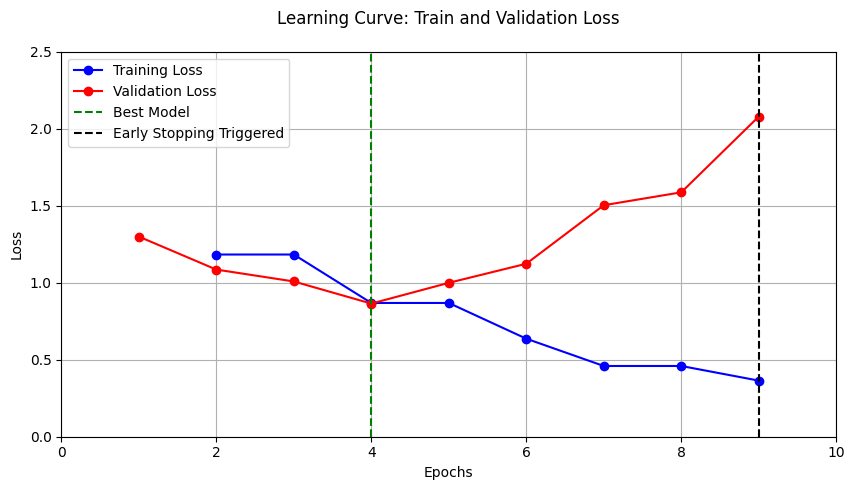

In [13]:
# Define epochs and loss values
epochs = np.arange(1, 10)
training_loss = np.array([None, 1.183100, 1.183100, 0.868600, 0.868600, 0.636600, 0.459300, 0.459300, 0.364300])
validation_loss = np.array([1.299673, 1.085420, 1.008179, 0.864529, 0.999262, 1.123220, 1.503293, 1.586980, 2.079169])

plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.plot(epochs[1:], training_loss[1:], label="Training Loss", marker="o", linestyle="-", color="blue")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="o", linestyle="-", color="red")

# Highlight epoch 4 (best model) and epoch 9 (early stopping triggered)
plt.axvline(x=4, linestyle="--", color="green", label="Best Model")
plt.axvline(x=9, linestyle="--", color="black", label="Early Stopping Triggered")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve: Train and Validation Loss", pad=20)

plt.xlim(0.0, 10)
plt.ylim(0.0, 2.5) 

plt.legend()
plt.grid(True)

# Show plot
plt.show()


## For DE run too we will hardcode, to know details check their respective notebooks

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


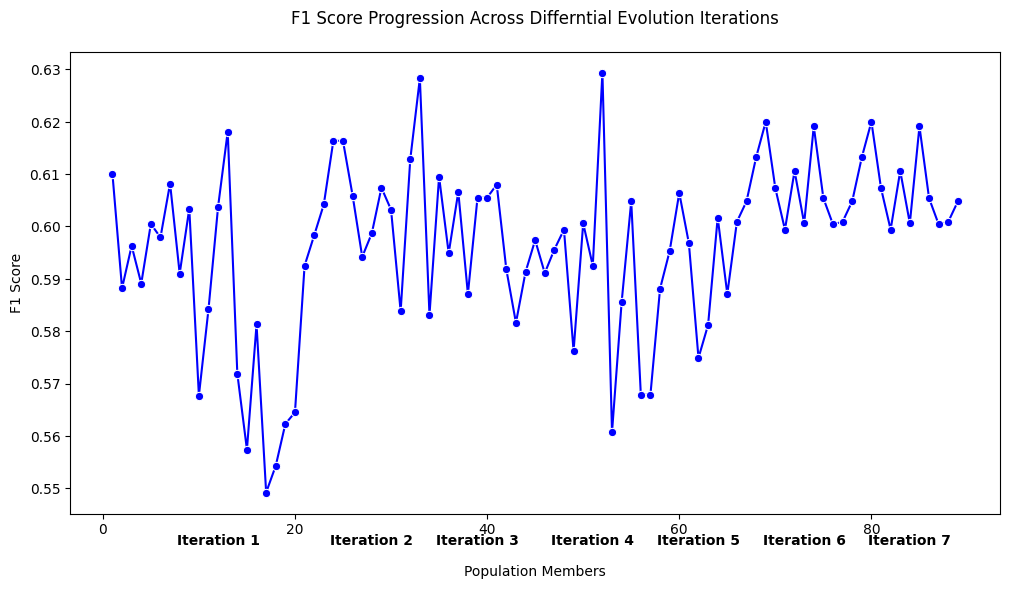

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
iterations = {
    1: [0.6101, 0.5882, 0.5963, 0.5891, 0.6005, 0.5979, 0.6082, 0.5910, 0.6034, 0.5677, 0.5842, 0.6038, 0.6181, 0.5719, 0.5574, 0.5813, 0.5492, 0.5543, 0.5623, 0.5645, 0.5925, 0.5983],
    2: [0.6042, 0.6164, 0.6163, 0.6059, 0.5942, 0.5987, 0.6074, 0.6032, 0.5838, 0.6128, 0.6283],
    3: [0.5831, 0.6095, 0.5949, 0.6066, 0.5871, 0.6055, 0.6055, 0.6080, 0.5918, 0.5816, 0.5913],
    4: [0.5974, 0.5911, 0.5956, 0.5994, 0.5762, 0.6006, 0.5925, 0.6294, 0.5607, 0.5855, 0.6048, 0.5679],
    5: [0.5679, 0.5881, 0.5953, 0.6064, 0.5968, 0.5749, 0.5812, 0.6017, 0.5871, 0.6009, 0.6048],
    6: [0.6132, 0.6200, 0.6073, 0.5994, 0.6106, 0.6006, 0.6191, 0.6054, 0.6004, 0.6009, 0.6048],
    7: [0.6132, 0.6200, 0.6073, 0.5994, 0.6106, 0.6006, 0.6191, 0.6054, 0.6004, 0.6009, 0.6048]
}

# Flatten data for plotting
x_vals = []
y_vals = []
iteration_labels = []
x_counter = 1

for i, values in iterations.items():
    x_vals.extend(range(x_counter, x_counter + len(values)))
    y_vals.extend(values)
    iteration_labels.append((x_counter + len(values) // 2, f'Iteration {i}'))
    x_counter += len(values)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_vals, y=y_vals, marker='o', linestyle='-', color='b')
plt.xlabel("Population Members", labelpad=20)
plt.ylabel("F1 Score")
plt.title("F1 Score Progression Across Differntial Evolution Iterations", pad=20)

# Annotate Iteration Labels
for x, label in iteration_labels:
    plt.text(x, min(y_vals) - 0.01, label, ha='center', fontsize=10, fontweight='bold', linespacing=30)

plt.show()
